In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy
from jax import numpy as jnp
from jax.config import config
# config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

sys.path.append('../../timeseries_jax/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src_jax/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
#from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(jnp.array(x_tr), observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(jnp.array(x_tr), observation_model=om_hs, state_model=sm_hs)
    hs_model.run()
    
    return hs_model

In [2]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()

In [3]:
smooth_window = 20
dz, du = observation_models.recommend_dims(x_tr, smooth_window=20)

In [8]:
dz, du = 3, 2

In [9]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=smooth_window)
ssm_em_lin.save(model_name='ssm_em_lin_energy', path='../../data/models/')

Iteration 3 - llk=-2154.3
Iteration 6 - llk=-1097.8
Iteration 9 - llk=-807.3
Iteration 12 - llk=-756.7
Iteration 15 - llk=-735.2
Iteration 18 - llk=-721.9
Iteration 21 - llk=-713.3
Iteration 24 - llk=-707.3
Iteration 27 - llk=-703.1
Iteration 30 - llk=-699.9
Iteration 33 - llk=-697.6
Iteration 36 - llk=-695.7
Iteration 39 - llk=-694.3
Iteration 42 - llk=-693.1
Iteration 45 - llk=-692.1
Iteration 48 - llk=-691.3
Iteration 51 - llk=-690.6
EM did converge.


In [9]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=smooth_window)
ssm_em_hsk.save(model_name='ssm_em_hsk_energy', path='../../data/models/')

Iteration 3 - llk=-1815.6
Iteration 6 - llk=-1011.9
Iteration 9 - llk=-797.5
Iteration 12 - llk=-759.4
Iteration 15 - llk=-739.3
Iteration 18 - llk=-728.2
Iteration 21 - llk=-724.5
Iteration 24 - llk=-722.1
Iteration 27 - llk=-720.4
Iteration 30 - llk=-719.2
Iteration 33 - llk=-714.6
Iteration 36 - llk=-713.9
EM did converge.


In [7]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_energy', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_energy', path='../../data/models/')

In [7]:
ssm_em_lin.compute_predictive_log_likelihood(jnp.array(x_te), ignore_init_samples=10)

NameError: name 'ssm_em_lin' is not defined

In [6]:
ssm_em_hsk.compute_predictive_log_likelihood(jnp.array(x_te), ignore_init_samples=10)

DeviceArray(-865.55845223, dtype=float64)

In [11]:
pred_hsk = ssm_em_hsk.compute_predictive_density(jnp.array(x_te))
pred_lin = ssm_em_lin.compute_predictive_density(jnp.array(x_te))

(913, 4)

Text(0.5, 0, 'Time steps')

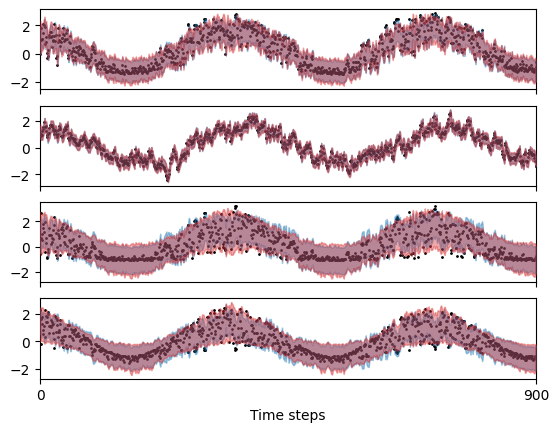

In [13]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

fig = pyplot.figure()
for idx in range(4):
    ax = fig.add_subplot(4,1,idx+1)
    pyplot.plot(x_te[10:1010,idx], 'k.', ms=2)
    pyplot.fill_between(range(900), mu_hsk[10:910,idx] - 1.68 * std_hsk[10:910,idx], mu_hsk[10:910,idx] + 1.68 * std_hsk[10:910,idx], color='C3', alpha=.4, zorder=9, label='heterosk.')
    pyplot.fill_between(range(900), mu_lin[10:910,idx] - 1.68 * std_lin[10:910,idx], mu_lin[10:910,idx] + 1.68 * std_lin[10:910,idx], color='C0', alpha=.4, zorder=7, label='homosk.')
    pyplot.xlim([0,900])
    pyplot.xticks([0,900], labels=[])
    pyplot.yticks([-2,0,2])
    #pyplot.ylim([-3,3])
pyplot.xticks([0,900], labels=[0,900])
#pyplot.legend(frameon=False)
idx = 2
pyplot.xlabel('Time steps')
#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')